# Using Census Data to Predict Adult Incomes

<b>Research Question:</b> Can we predict which inidiviuals make more than $50,000 per year based on demographic data from the 1994 census?

<b>Data:</b> Data was taken from Kaggle.com and originally extracted from the 1996 Census Bureau Database by Ronny Kohavi and Barry Becker. The data includes individuals that are over the age of 16 and have an Adjusted Gross Income of at least $100 dollars. 

<b>Methodology</b>: Will compare the performance of three binary classification models: 
-  Logistics Regression
-  Random Forest
-  Gradient Boosting 

In [142]:
#=================================================-
#### Directory settings  ####

# Set `main_dir` to the location of your `bah-intermediate` folder (for Mac).
main_dir = '/Users/warrenasfazadour/desktop/bah-intermediate/Capstone'

# Make `data_dir` from the `main_dir` and
# remainder of the path to data directory.
data_dir = main_dir + "/data"



In [143]:
#=================================================-
#### Loading packages  ####

# Silence all warnings 
import warnings
warnings.filterwarnings('ignore')

# Helper packages.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from textwrap import wrap
import pickle
# Scikit-learn package for logistic regression.
from sklearn import linear_model
# Model set up and tuning packages from scikit-learn.
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# Scikit-learn packages for evaluating model performance.
from sklearn import metrics
# Scikit-learn package for data preprocessing.
from sklearn import preprocessing

# Random forests and boosting packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier



In [144]:
#=================================================-
#### Working directory  ####

# Set working directory.
os.chdir(data_dir)
# Check working directory.
print(os.getcwd())



/Users/warrenasfazadour/Desktop/bah-intermediate/Capstone/Data


### Part I: Data Exploration & Preparation

In [145]:
#=================================================-
#### Loading data into Python  ####

census = pd.read_csv("adult.csv")
print(census.head())



   age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1          4356              18  United-States

In [146]:
#=================================================-
#### The data at first glance  ####

# The data types.
print(census.dtypes)


age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object


In [147]:
#=================================================-
#### Frequency table of the target variable & total Observations  ####

print(census['income'].value_counts())

# Insert a line break
print('\n')

# Total observations
total_observations = len(census)
print('Total Observations: ' + str(total_observations))



<=50K    24720
>50K      7841
Name: income, dtype: int64


Total Observations: 32561


In [148]:
#=================================================-
#### Data prep: check for NAs  ####

# Check for NAs.
#print(census.isnull().sum())

# Replace unknown ('?') information with null
census = census.replace(to_replace='?', value=np.NaN)
print(census.isnull().sum())


age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


In [149]:
#=================================================-
#### Data prep: target  ####

print(census.income.dtypes)
census["income"] = np.where(census["income"] == '>50K', True, False)

# Check class again.
print(census.income.dtypes)
print(census['income'].sum())

object
bool
7841


In [150]:
#=================================================-
#### Working with categorical variables  ####

print(census['marital.status'].head())
print('\n')
print(census['relationship'].head())
print('\n')
print(census['race'].head())
print('\n')
print(census['sex'].head())
print('\n')
print(census['native.country'].head())

0      Widowed
1      Widowed
2      Widowed
3     Divorced
4    Separated
Name: marital.status, dtype: object


0    Not-in-family
1    Not-in-family
2        Unmarried
3        Unmarried
4        Own-child
Name: relationship, dtype: object


0    White
1    White
2    Black
3    White
4    White
Name: race, dtype: object


0    Female
1    Female
2    Female
3    Female
4    Female
Name: sex, dtype: object


0    United-States
1    United-States
2    United-States
3    United-States
4    United-States
Name: native.country, dtype: object


In [151]:
#=================================================-
#### Working with categorical variables  ####

print(census['marital.status'].value_counts())
print('\n')
print(census['relationship'].value_counts())
print('\n')
print(census['race'].value_counts())
print('\n')
print(census['sex'].value_counts())
print('\n')
print(census['native.country'].value_counts())


Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital.status, dtype: int64


Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64


White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64


Male      21790
Female    10771
Name: sex, dtype: int64


United-States                 29170
Mexico                          643
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England           

In [152]:
#=================================================-
#### Working with categorical variables  ####

# Consolidate marital status into three categories
census["marital.status"] = np.where((census["marital.status"] == 'Married-civ-spouse') | (census['marital.status'] == 'Married-AF-spouse'), 'Married', np.where(census['marital.status'] == 'Never-married', 'Single', 'Previously-Married'))

print(census['marital.status'].value_counts())

Married               14999
Single                10683
Previously-Married     6879
Name: marital.status, dtype: int64


In [153]:
#=================================================-
#### Transform and replace other categorical variables  ####

# Convert 'marital.status' into dummy variables.
marital_status_dummy = pd.get_dummies(census['marital.status'], drop_first = True)
# Convert 'sex' into dummy variables.
sex_dummy = pd.get_dummies(census['sex'], prefix='sex', drop_first = True)
# Convert 'race' into dummy variables.
race_dummy = pd.get_dummies(census['race'], prefix = 'race', drop_first = True)
# Drop `marital.status` `sex` and `race`from the data.
census.drop(['marital.status', 'sex', 'race'], axis = 1, inplace = True)
# Concatenate `marital.status` `sex_dummy` and `race_dummy` to our dataset.
census = pd.concat([census,marital_status_dummy,sex_dummy,race_dummy],axis=1)
print(census.head())


   age workclass  fnlwgt     education  education.num         occupation  \
0   90       NaN   77053       HS-grad              9                NaN   
1   82   Private  132870       HS-grad              9    Exec-managerial   
2   66       NaN  186061  Some-college             10                NaN   
3   54   Private  140359       7th-8th              4  Machine-op-inspct   
4   41   Private  264663  Some-college             10     Prof-specialty   

    relationship  capital.gain  capital.loss  hours.per.week native.country  \
0  Not-in-family             0          4356              40  United-States   
1  Not-in-family             0          4356              18  United-States   
2      Unmarried             0          4356              40  United-States   
3      Unmarried             0          3900              40  United-States   
4      Own-child             0          3900              40  United-States   

   income  Previously-Married  Single  sex_Male  race_Asian-Pac-Isla

In [154]:
#=================================================-
#### Split into train and test set  ####

# Separate predictors from data.
# We can just drop the target variable, as we are using all other variables as predictors.
X = census.drop(['workclass',
                'hours.per.week',
                'fnlwgt', 
                'education', 
                'occupation', 
                'relationship', 
                'capital.gain', 
                'capital.loss', 
                'native.country',
                'income'], axis = 1)
# Separate target from data.
y = np.array(census['income'])
# Set the seed.
np.random.seed(1)
# Split data into training and test sets, use a 70 train - 30 test split.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .3)



In [155]:
#=================================================-
#### Balance target with SMOTE  ####

from imblearn.over_sampling import SMOTE

#Initialize SMOTE object.
smote = SMOTE()

#Fit the sampling method to our train data and labels.
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

#Print previous and current target value counts
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(y_train_sm, return_counts=True)
print(dict(zip(unique, counts)))

#Save the oversampled training data back to original variables
X_train, y_train = X_train_sm, y_train_sm

{False: 17352, True: 5440}
{False: 17352, True: 17352}


### Part II: Modeling - Logistics Regression

In [156]:
#=================================================-
#### Logistic regression: build  ####

# Set up logistic regression model.
logistic_regression_model = linear_model.LogisticRegression(max_iter=1000, solver='lbfgs')
print(logistic_regression_model)



LogisticRegression(max_iter=1000)


In [157]:
#=================================================-
#### Logistic regression: fit  ####

# Fit the model.
logistic_regression_model.fit(X_train,y_train)



LogisticRegression(max_iter=1000)

In [158]:
#=================================================-
#### Logistic regression: predict  ####

# Predict on test data.
predicted_values = logistic_regression_model.predict(X_test)
print(predicted_values)



[False  True False ... False False  True]


In [159]:
#=================================================-
#### Logistics Regression: Confusion matrix and accuracy  ####

# Take a look at test data confusion matrix.
conf_matrix_test = metrics.confusion_matrix(y_test, predicted_values)
print(conf_matrix_test)
# Compute test model accuracy score.
test_accuracy_score = metrics.accuracy_score(y_test, predicted_values)
print("Accuracy on test data: ", test_accuracy_score)


test_recall_score = metrics.recall_score(y_test, predicted_values)
print("Recall on test data: ", test_recall_score)


[[5461 1907]
 [ 383 2018]]
Accuracy on test data:  0.7655850138192241
Recall on test data:  0.8404831320283215


In [160]:
#=================================================-
#### Logistics Regression: Accuracy on train vs accuracy on test  ####

# Compute trained model accuracy score.
trained_accuracy_score = logistic_regression_model.score(X_train, y_train)
print("Accuracy on test data: " , test_accuracy_score)

# Compute trained model accuracy score.
trained_accuracy_score_train = logistic_regression_model.score(X_train, y_train)
print("Accuracy on train data: " , trained_accuracy_score)



Accuracy on test data:  0.7655850138192241
Accuracy on train data:  0.8029333794375288


In [161]:
#=================================================-
#### Logistics Regression: Classification report  ####

# Create a list of target names to interpret class assignments.
target_names = ['<=50K', '>50K']

# Print an entire classification report.
class_report = metrics.classification_report(y_test,
                                            predicted_values,
                                            target_names = target_names)

print(class_report)
print('\n')


predicted_values_train = logistic_regression_model.predict(X_train) 
print(predicted_values_train)

recall_score_train = metrics.recall_score(y_train, predicted_values_train)

print(recall_score_train)




              precision    recall  f1-score   support

       <=50K       0.93      0.74      0.83      7368
        >50K       0.51      0.84      0.64      2401

    accuracy                           0.77      9769
   macro avg       0.72      0.79      0.73      9769
weighted avg       0.83      0.77      0.78      9769



[ True  True False ...  True  True  True]
0.8713116643614569


In [162]:
#=================================================-
#### Create a model champion dataframe  ####

# Create a dictionary with accuracy values for our logistic regression model.
model_final_dict = {'metrics': ["accuracy"],
'values':[round(test_accuracy_score, 4)],
'model':['logistic']}

model_final = pd.DataFrame(data = model_final_dict)



In [163]:
#=================================================-
#### Logistics Regression: Getting probabilities instead of class labels  ####

# Get probabilities instead of predicted values.
test_probabilities = logistic_regression_model.predict_proba(X_test)
print(test_probabilities[0:5, :])
# Get probabilities of test predictions only.
test_predictions = test_probabilities[:, 1]
print(test_predictions[0:5])



[[0.81691529 0.18308471]
 [0.14106098 0.85893902]
 [0.97639287 0.02360713]
 [0.11223897 0.88776103]
 [0.77755076 0.22244924]]
[0.18308471 0.85893902 0.02360713 0.88776103 0.22244924]


In [164]:
#=================================================-
#### Logistics Regression: Computing FPR, TPR, and threshold  ####

# Get FPR, TPR, and threshold values.
fpr, tpr, threshold = metrics.roc_curve(y_test,            #<- test data labels
                                        test_predictions)  #<- predicted probabilities
print("False positive: ", fpr[:5])
print("True positive: ", tpr[:5])
print("Threshold: ", threshold[:5])



False positive:  [0. 0. 0. 0. 0.]
True positive:  [0.         0.00041649 0.00249896 0.00333195 0.00416493]
Threshold:  [1.99326445 0.99326445 0.98023826 0.97972515 0.97862461]


In [165]:
#=================================================-
#### Logistics Regressions: Computing AUC  ####

# Get AUC by providing the FPR and TPR.
auc = metrics.auc(fpr, tpr)
print("Area under the ROC curve: ", auc)



Area under the ROC curve:  0.8680059340095807


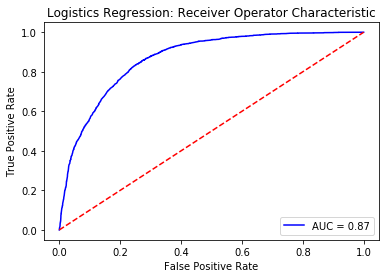

In [166]:
#=================================================-
#### Logistics Regression: ROC plot  ####

# Make an ROC curve plot.
plt.title('Logistics Regression: Receiver Operator Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()



In [167]:
#=================================================-
#### Logistics Regression: Prepare parameters for optimization  ####

# Create regularization penalty space.
penalty = ['none', 'l2']
# Create regularization constant space.
C = np.logspace(0, 10, 10)
print("Regularization constant: ", C)
# Create hyperparameter options dictionary.
hyperparameters = dict(C = C, penalty = penalty)
print(hyperparameters)




Regularization constant:  [1.00000000e+00 1.29154967e+01 1.66810054e+02 2.15443469e+03
 2.78255940e+04 3.59381366e+05 4.64158883e+06 5.99484250e+07
 7.74263683e+08 1.00000000e+10]
{'C': array([1.00000000e+00, 1.29154967e+01, 1.66810054e+02, 2.15443469e+03,
       2.78255940e+04, 3.59381366e+05, 4.64158883e+06, 5.99484250e+07,
       7.74263683e+08, 1.00000000e+10]), 'penalty': ['11', 'l2']}


In [168]:
#=================================================-
#### Logistics Regression: Set up cross-validation logistic function  ####

# Grid search 10-fold cross-validation with above parameters.
clf = GridSearchCV(linear_model.LogisticRegression(solver='lbfgs'), #<- function to optimize
hyperparameters,                   #<- grid search parameters
cv = 10,                           #<- 10-fold cv
verbose = 0)                       

# Fit CV grid search.
best_model = clf.fit(X_train, y_train) 



In [169]:
#=================================================-
#### Logistics Regression: Check best parameters found by CV  ####

# Get best penalty and constant parameters.
penalty = best_model.best_estimator_.get_params()['penalty'] 
constant = best_model.best_estimator_.get_params()['C'] 
print('Best penalty: ', penalty)
print('Best C: ', constant)



Best penalty:  l2
Best C:  10000000000.0


In [170]:
#=================================================-
#### Slide 98: Predict using the best model parameters  ####

# Predict on test data using best model.
best_predicted_values = best_model.predict(X_test) 
print(best_predicted_values)

# Compute best model accuracy score.
best_accuracy_score = metrics.accuracy_score(y_test, best_predicted_values) 
print("Accuracy on test data (best model): ", best_accuracy_score)
best_recall_score = metrics.recall_score(y_test, best_predicted_values) 
print("Recall on test data (best model): ", best_recall_score)


# Predict on test data using best model.
best_predicted_values_train = best_model.predict(X_train) 
print(best_predicted_values_train)

# Compute best model accuracy score.
best_accuracy_score_train = metrics.accuracy_score(y_train, best_predicted_values_train) 
print("Accuracy on train data (best model): ", best_accuracy_score_train)
best_recall_score_train = metrics.recall_score(y_train, best_predicted_values_train) 
print("Recall on train data (best model): ", best_recall_score_train)

[False  True False ... False False  True]
Accuracy on test data (best model):  0.7659944723103695
Recall on test data (best model):  0.844231570179092
[ True  True False ...  True  True  True]
Accuracy on train data (best model):  0.801982480405717
Recall on train data (best model):  0.8719455970493315


In [171]:
#=================================================-
#### Slide 99: Predict using the best model parameters (cont'd)  ####

# Compute confusion matrix for best model.
best_confusion_matrix = metrics.confusion_matrix(y_test, best_predicted_values) 
print(best_confusion_matrix)

# Compute classification report for best model.
best_class_report = metrics.classification_report(y_test, best_predicted_values,
                                                  target_names = target_names)
print(best_class_report)

[[5456 1912]
 [ 374 2027]]
              precision    recall  f1-score   support

       <=50K       0.94      0.74      0.83      7368
        >50K       0.51      0.84      0.64      2401

    accuracy                           0.77      9769
   macro avg       0.73      0.79      0.73      9769
weighted avg       0.83      0.77      0.78      9769



### Part III: Modeling - Random Forest

In [172]:
#=================================================-
#### Random Forest: Building our model  ####

forest = RandomForestClassifier(criterion = 'gini',n_estimators = 100,random_state = 1)



In [173]:
#=================================================-
#### Random Forest: Fitting our model  ####

# Fit the saved model to your training data.
forest.fit(X_train, y_train)



RandomForestClassifier(random_state=1)

In [174]:
#=================================================-
#### Random Forest: Predicting with our data  ####

# Predict on test data.
y_predict_forest = forest.predict(X_test)

# Look at the first few predictions.
print(y_predict_forest[0:5,])



[False  True False  True False]


In [175]:
#=================================================-
#### Random Forest: Confusion matrix and accuracy  ####

# Take a look at test data confusion matrix.
conf_matrix_forest = metrics.confusion_matrix(y_test, y_predict_forest)
print(conf_matrix_forest)
accuracy_forest = metrics.accuracy_score(y_test, y_predict_forest)
print("Accuracy for random forests on test data: ", accuracy_forest)



[[5589 1779]
 [ 524 1877]]
Accuracy for random forests on test data:  0.7642542737230014


In [176]:
#=================================================-
#### Random Forest: Accuracy of the training dataset ####

# Compute accuracy using training data.
acc_train_forest = forest.score(X_train, y_train)

print ("Train Accuracy:", acc_train_forest)



Train Accuracy: 0.852293683725219


In [177]:
#=================================================-
#### Random Forest: Classification report ####

# Print an entire classification report.
class_report = metrics.classification_report(y_test,
                                            y_predict_forest,
                                            target_names = target_names)

print(class_report)

              precision    recall  f1-score   support

       <=50K       0.91      0.76      0.83      7368
        >50K       0.51      0.78      0.62      2401

    accuracy                           0.76      9769
   macro avg       0.71      0.77      0.72      9769
weighted avg       0.82      0.76      0.78      9769



In [178]:
#=================================================-
#### Random Forest: Add accuracy to the Model Champion dataframe  ####

# Add the model to our dataframe.
model_final = model_final.append({'metrics': "accuracy",
                                  'values':round(accuracy_forest,4),
                                  'model':'random_forest'},ignore_index = True)



In [179]:
#=================================================-
#### Random Forest: Getting probabilities instead of class labels  ####

# Get probabilities instead of predicted values.
test_probabilities_forest = forest.predict_proba(X_test)
print(test_probabilities_forest[0:5, :])
# Get probabilities of test predictions only.
test_predictions_forest = test_probabilities_forest[:, 1]
print(test_predictions_forest[0:5])

[[0.92936905 0.07063095]
 [0.15335171 0.84664829]
 [1.         0.        ]
 [0.12018689 0.87981311]
 [0.85535426 0.14464574]]
[0.07063095 0.84664829 0.         0.87981311 0.14464574]


In [180]:
#=================================================-
#### Random Forest: Computing FPR, TPR, and threshold  ####

# Get FPR, TPR, and threshold values.
fpr_f, tpr_f, threshold_f = metrics.roc_curve(y_test,            #<- test data labels
                                        test_predictions_forest)  #<- predicted probabilities
print("False positive: ", fpr_f[:5])
print("True positive: ", tpr_f[:5])
print("Threshold: ", threshold_f[:5])

False positive:  [0.         0.00434311 0.00434311 0.00461455 0.00475027]
True positive:  [0.         0.05664307 0.05705956 0.05747605 0.05747605]
Threshold:  [2.         1.         0.99909091 0.99875    0.99866667]


In [181]:
#=================================================-
#### Random Forest: Computing AUC  ####

# Get AUC by providing the FPR and TPR.
auc_f = metrics.auc(fpr_f, tpr_f)
print("Area under the ROC curve: ", auc_f)

Area under the ROC curve:  0.8476623531816504


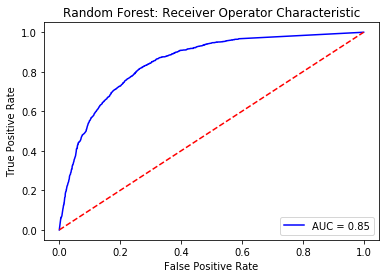

In [182]:
#=================================================-
#### Random Forest: ROC plot  ####

# Make an ROC curve plot.
plt.title('Random Forest: Receiver Operator Characteristic')
plt.plot(fpr_f, tpr_f, 'b', label = 'AUC = %0.2f' % auc_f)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Text(0.5, 0, 'Relative Importance')

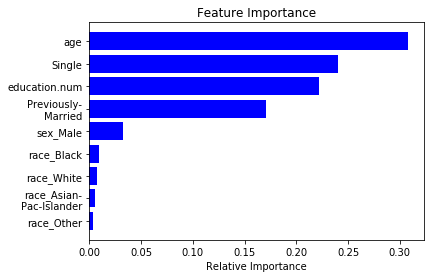

In [183]:
#=================================================-
#### Random Forest: Subsetting our features  ####

#census_features = X.drop('income', axis = 1)
features = X.columns
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
top_indices = indices[0:10][::-1]

plt.figure(1)
plt.title('Feature Importance')
plt.barh(range(len(top_indices)), importances[top_indices], color = 'b', align = 'center')
labels = features[top_indices]
labels = [ '\n'.join(wrap(l,13)) for l in labels ]
plt.yticks(range(len(top_indices)), labels)
plt.xlabel('Relative Importance')

### Part IV: Modeling - Gradient Boosting

In [184]:
#=================================================-
#### Boosting: build model  ####

# Save the parameters we will be using for our gradient boosting classifier.
gbm = GradientBoostingClassifier(n_estimators = 200,learning_rate = 1,max_depth = 2,random_state = 1)



In [185]:
#=================================================-
#### Boosting: fit model  ####

# Fit the saved model to your training data.
gbm.fit(X_train, y_train)



GradientBoostingClassifier(learning_rate=1, max_depth=2, n_estimators=200,
                           random_state=1)

In [186]:
#=================================================-
#### Boosting: predict  ####

# Predict on test data.
predicted_values_gbm = gbm.predict(X_test)
print(predicted_values_gbm)



[False  True False ... False False  True]


In [187]:
#=================================================-
#### Boosting: Confusion matrix and accuracy  ####

# Take a look at test data confusion matrix.
conf_matrix_boosting = metrics.confusion_matrix(y_test, predicted_values_gbm)
print(conf_matrix_boosting)
# Compute test model accuracy score.
accuracy_gbm = metrics.accuracy_score(y_test, predicted_values_gbm)
print('Accuracy of gbm on test data: ', accuracy_gbm)



[[5632 1736]
 [ 426 1975]]
Accuracy of gbm on test data:  0.7786876855358787


In [188]:
#=================================================-
#### Boosting: Accuracy of training model  ####

# Compute accuracy using training data.
train_accuracy_gbm = gbm.score(X_train, y_train)

print ("Train Accuracy:", train_accuracy_gbm)



Train Accuracy: 0.8196461502996772


In [189]:
#=================================================-
#### Boosting: Classification report  ####

# Create a list of target names to interpret class assignments.
target_names = ['<=50K', '>50K']

# Print an entire classification report.
class_report = metrics.classification_report(y_test,
                                            predicted_values_gbm,
                                            target_names = target_names)

print(class_report)

              precision    recall  f1-score   support

       <=50K       0.93      0.76      0.84      7368
        >50K       0.53      0.82      0.65      2401

    accuracy                           0.78      9769
   macro avg       0.73      0.79      0.74      9769
weighted avg       0.83      0.78      0.79      9769



In [190]:
#=================================================-
#### Add final accuracy to the Model Champion dataframe  ####

# Add the model to our dataframe.
model_final = model_final.append(
{'metrics' : "accuracy" ,
'values' : round(accuracy_gbm,4),
'model': 'boosting' } ,
ignore_index = True)



In [191]:
#=================================================-
#### Boosting: Getting probabilities instead of class labels  ####

# Get probabilities instead of predicted values.
test_probabilities_gbm = gbm.predict_proba(X_test)
print(test_probabilities_gbm[0:5, :])
# Get probabilities of test predictions only.
test_predictions_gbm = test_probabilities_gbm[:, 1]
print(test_predictions_gbm[0:5])

[[9.39291487e-01 6.07085135e-02]
 [1.31956271e-01 8.68043729e-01]
 [9.99982149e-01 1.78508941e-05]
 [1.05456431e-01 8.94543569e-01]
 [9.23459026e-01 7.65409744e-02]]
[6.07085135e-02 8.68043729e-01 1.78508941e-05 8.94543569e-01
 7.65409744e-02]


In [192]:
#=================================================-
#### Boosting: Computing FPR, TPR, and threshold  ####

# Get FPR, TPR, and threshold values.
fpr_gbm, tpr_gbm, threshold_gbm = metrics.roc_curve(y_test,            #<- test data labels
                                        test_predictions_gbm)  #<- predicted probabilities
print("False positive: ", fpr_gbm[:5])
print("True positive: ", tpr_gbm[:5])
print("Threshold: ", threshold_gbm[:5])

False positive:  [0.         0.00067861 0.00067861 0.00081433 0.00081433]
True positive:  [0.         0.         0.00041649 0.00041649 0.00249896]
Threshold:  [2.         1.         0.99462795 0.9913499  0.98719717]


In [193]:
#=================================================-
#### Boosting: Computing AUC  ####

# Get AUC by providing the FPR and TPR.
auc_gbm = metrics.auc(fpr_gbm, tpr_gbm)
print("Area under the ROC curve: ", auc_gbm)

Area under the ROC curve:  0.8735567733042828


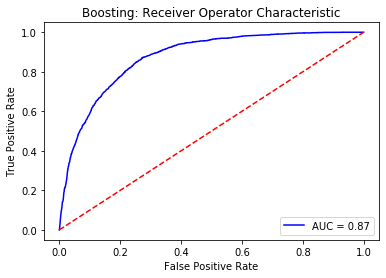

In [194]:
#=================================================-
#### Boosting: ROC plot  ####

# Make an ROC curve plot.
plt.title('Boosting: Receiver Operator Characteristic')
plt.plot(fpr_gbm, tpr_gbm, 'b', label = 'AUC = %0.2f' % auc_gbm)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Text(0.5, 0, 'Relative Importance')

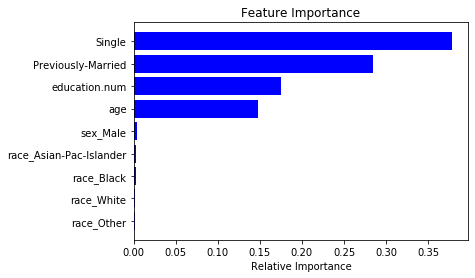

In [195]:
#=================================================-
#### Boosting: Top 10 features  ####

features = X.columns
importances = gbm.feature_importances_
indices = np.argsort(importances)[::-1]
top_indices = indices[0:10][::-1]

plt.figure(1)
plt.title('Feature Importance')
plt.barh(range(len(top_indices)), importances[top_indices], color = 'b', align = 'center')
labels = features[top_indices]
labels = [ '\n'.join(wrap(l,13)) for l in labels ]
plt.yticks(range(len(top_indices)), features[top_indices])
plt.xlabel('Relative Importance')

### Part V: Cumulative Results 

In [196]:
#=================================================-
#### Compare all accuracy scores  ####
print(model_final)



    metrics  values          model
0  accuracy  0.7656       logistic
1  accuracy  0.7643  random_forest
2  accuracy  0.7787       boosting


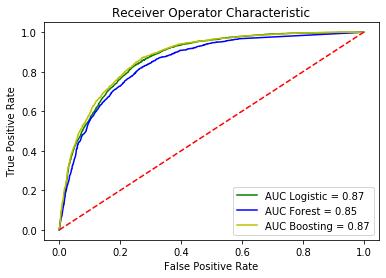

In [197]:
#=================================================-
#### ROC plot  ####

# Make an ROC curve plot.
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, 'g', label = 'AUC Logistic = %0.2f' % auc)
plt.plot(fpr_f, tpr_f, 'b', label = 'AUC Forest = %0.2f' % auc_f)
plt.plot(fpr_gbm, tpr_gbm, 'y', label = 'AUC Boosting = %0.2f' % auc_gbm)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Part VI: Conclusions

All three models did well based on accuracy. Therefore it can be said that census demographic data can be used to accurately predict whether an individual makes over $50,000 a year. 

While the Gradient Boosting classifier did slightly better than the Random Forest Model and the Logistics Regression Model. There is still potential for improvement; neither of the esemble models have been tuned.